# FACE: Facial Associative Coupling in Expression - processing pipeline

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import util.feature_selection as fs
import util.correlation_measure as cm
import util.validation_testing as val
import util.toolbox as toolbox

from scipy.stats import spearmanr, linregress
from collections import Counter


In [ ]:
# Setting constants, preparing file structure, checking file content
SAVE_FIG = False


LOCATION = "data"
ACTION_UNITS = "data/au"
FEATURE_FOLDER = "features"
CORRELATION_FOLDER = 'correlations'

PHASES = ['instructional_video_0', 'discussion_phase_0', *[f'reschu_run_{i}' for i in range(4)], 'discussion_phase_1', *[f'reschu_run_{4+i}' for i in range(4)]]
FACTORS = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']

FACTOR_LABELS = {
    'f1': "Enjoyment Smile",
    'f2': "Eyebrows Up",
    'f3': "Mouth Open",
    'f4': "Mouth Tightening",
    'f5': "Eye Tightening",
    'f6': "Mouth Frown"
}


NON_EVENT_MATCHES = 'excluded'
remove_nem = (NON_EVENT_MATCHES == 'excluded')
if remove_nem:
    ANALYSIS_FILENAME = 'results/NEM excl/crqa_NEM-'
else: 
    ANALYSIS_FILENAME = 'results/NEM incl/crqa_NEM+'

RESPONSE_VARIABLE = 'score'

    
REMOVE_NEM = {
    'f1': remove_nem,
    'f2': remove_nem,
    'f3': remove_nem,
    'f4': remove_nem,
    'f5': remove_nem,
    'f6': remove_nem,
    }

if remove_nem:
    RADIUS = {
        'f1': 0.075,
        'f2': 0.075, 
        'f3': 0.05,
        'f4': 0.05,
        'f5': 0.1,
        'f6': 0.025,
        }
else:
    RADIUS = {
        'f1': 0.001,
        'f2': 0.001, 
        'f3': 0.025,
        'f4': 0.025,
        'f5': 0.05,
        'f6': 0.025,
        }

PAIRS = [f'0{i}_0{i+1}' for i in np.arange(5,9,2)] + ["09_10"] + [f'{i}_{i+1}' for i in np.arange(11,104,2)]


AVAILABLE_PAIRS = [] # ['05_06', '07_08', '09_10', '99_100', '101_102', '103_104', '13_14', '15_16', '17_18', '19_20', '21_22', '25_26', '27_28', '29_30', '31_32', '33_34', '35_36', '37_38', '39_40', '41_42', '43_44', '45_46', '47_48', '49_50', '51_52', '59_60', '61_62', '65_66', '67_68', '69_70', '71_72', '73_74', '75_76', '77_78', '79_80', '81_82', '83_84', '85_86', '87_88', '91_92', '93_94', '95_96', '97_98']
missing_all = ['11_12', '15_16', '23_24', '57_58', '89_90']
missing_more_than_4 =  ['53_54', '55_56', "63_64", "89_90"] #  ['17_18', '35_36', '43_44', '61_62', '65_66', '75_76', '77_78', '79_80', '99_100']
SKIP_PAIRS = missing_all + missing_more_than_4 


# make dirs
for file in os.listdir(ACTION_UNITS):
    if ".csv" in file and 'Data' in file: 
        filename = os.path.join(ACTION_UNITS, file)
        participant, _ = file.split("_",1)
        participant = participant[2:]
        for p in PAIRS:
            p1,p2 = p.split("_")
            if participant == p1 or participant == p2:
                pair = p
                break
        if pair in SKIP_PAIRS:
            continue
        if pair not in AVAILABLE_PAIRS:
            AVAILABLE_PAIRS.append(pair)
            dir = os.path.join(LOCATION, pair)
            os.makedirs(dir, exist_ok=True)
            dir = os.path.join(LOCATION, pair, FEATURE_FOLDER)
            os.makedirs(dir, exist_ok=True)
            dir = os.path.join(LOCATION, pair, CORRELATION_FOLDER)
            os.makedirs(dir, exist_ok=True)

print(f"Found {len(AVAILABLE_PAIRS)} available pairs to process.")


# SCORES OUT OF RESCHU
scores = pd.read_csv('RESCHU-data/teamscores_allParticipants_filtered.csv')
scores = scores[['SubjectId', 'reschuRun', 'TeamTotal']]

RESCHU_DATA = {}
for pair in AVAILABLE_PAIRS:
    p1, _ = pair.split("_")
    df = scores[scores['SubjectId'] == int(p1)]
    score = [[df['reschuRun'].values[i], df['TeamTotal'].values[i]] for i in range(len(df))]
    RESCHU_DATA[pair] = {
        'score' : score,
        'zoom'  : (int(p1)-1)%4 < 2,
        'beeps' : [int(p1) % 4 == 1, int(p1) % 4 != 1] * 4
    }
RESCHU_DATA['51_52']['score'] = [[0, None]] + RESCHU_DATA['51_52']['score'] # because 51_52 misses the score for reschu_run_0

# print example RESCHU data
print(f'Example RESCHU data for pair 51_52: \nscore: {RESCHU_DATA['51_52']['score']}\nzoom: {RESCHU_DATA['51_52']['zoom']}\nbeeps: {RESCHU_DATA['51_52']['beeps']}')


# Check for missing data
missing_pairs = []
phase_missing = {}
missing_counts = {}

for pair in PAIRS:
    if pair in SKIP_PAIRS:
        missing_pairs.append(pair)
        continue
    p1, p2 = pair.split("_")
    missing_phases = []
    
    for phase in PHASES:
        p1_file = os.path.join(ACTION_UNITS, f"pp{p1}_navigator_{phase}_AU_withMissingData.csv")
        p2_file = os.path.join(ACTION_UNITS, f"pp{p2}_pilot_{phase}_AU_withMissingData.csv")
        
        if not (os.path.exists(p1_file) and os.path.exists(p2_file)):
            missing_phases.append(phase)
    
    if len(missing_phases) == len(PHASES):
        missing_pairs.append(pair)
    elif missing_phases:
        phase_missing[pair] = missing_phases
        # Update missing counts statistics
        count = len(missing_phases)
        missing_counts[count] = missing_counts.get(count, 0) + 1


# Generate report
total_pairs = len(PAIRS)
max_phases = len(PHASES)

print("\n\n=== Data Completeness Report ===")
print(f"\nTotal pairs processed: {total_pairs}")
print(f"\nPairs with missing data: {len(missing_pairs) + len(phase_missing)}")
print(f"Complete pairs (no missing phases): {total_pairs - len(missing_pairs) - len(phase_missing)}")

print("\nMissing phases summary:")
print(f"- Missing all phases ({max_phases}): {len(missing_pairs)}")
for count in sorted(missing_counts.keys()):
    print(f"- Missing {count} phase(s): {missing_counts[count]}")

print("\nDetailed breakdown:")
print("\nPairs with all phases missing:")
if missing_pairs:
    for pair in missing_pairs:
        print(f"  - {pair}")
else:
    print("  None")

print("\nPairs with specific phases missing:")
if phase_missing:
    for pair, phases in phase_missing.items():
        print(f"  - {pair}: Missing {len(phases)} phases ({', '.join(phases)})")
else:
    print("  None")

# New: Count total missing occurrences per phase
print("\nMissing data count per phase:")
phase_counter = Counter()
for phases in phase_missing.values():
    phase_counter.update(phases)

# Sort output by number of missing occurrences (descending)
for phase, count in phase_counter.most_common():
    print(f"  - {phase}: missing in {count} pair(s)")


Found 42 available pairs to process.
Example RESCHU data for pair 51_52: 
score: [[0, None], [1, 5], [2, 1], [3, 10], [4, 3], [5, 11], [6, 8], [7, 12]]
zoom: False
beeps: [False, True, False, True, False, True, False, True]


=== Data Completeness Report ===

Total pairs processed: 50

Pairs with missing data: 36
Complete pairs (no missing phases): 14

Missing phases summary:
- Missing all phases (11): 8
- Missing 1 phase(s): 6
- Missing 2 phase(s): 3
- Missing 3 phase(s): 3
- Missing 4 phase(s): 7
- Missing 5 phase(s): 6
- Missing 6 phase(s): 1
- Missing 7 phase(s): 1
- Missing 9 phase(s): 1

Detailed breakdown:

Pairs with all phases missing:
  - 11_12
  - 15_16
  - 23_24
  - 53_54
  - 55_56
  - 57_58
  - 63_64
  - 89_90

Pairs with specific phases missing:
  - 05_06: Missing 1 phases (instructional_video_0)
  - 17_18: Missing 6 phases (reschu_run_3, discussion_phase_1, reschu_run_4, reschu_run_5, reschu_run_6, reschu_run_7)
  - 19_20: Missing 1 phases (discussion_phase_0)
  - 25_26:

In [3]:
print(AVAILABLE_PAIRS)

['05_06', '07_08', '09_10', '99_100', '101_102', '103_104', '13_14', '17_18', '19_20', '21_22', '25_26', '27_28', '29_30', '31_32', '33_34', '35_36', '37_38', '39_40', '41_42', '43_44', '45_46', '47_48', '49_50', '51_52', '59_60', '61_62', '65_66', '67_68', '69_70', '71_72', '73_74', '75_76', '77_78', '79_80', '81_82', '83_84', '85_86', '87_88', '91_92', '93_94', '95_96', '97_98']


# Feature selection


In [4]:
## EXTRACTING FACIAL FACTORS AND CORRCA FOR EACH FILE SEPARATELY
if False: # set to False to prevent unnecessary processing
    for pair in AVAILABLE_PAIRS:
        print(f"{pair} is being processed...")
        p1, p2 = pair.split("_")
        for phase in PHASES: 
            p1_file = os.path.join(ACTION_UNITS, f"pp{p1}_navigator_{phase}_AU_withMissingData.csv")
            p2_file = os.path.join(ACTION_UNITS, f"pp{p2}_pilot_{phase}_AU_withMissingData.csv")

            if os.path.exists(p1_file) and os.path.exists(p2_file): # make sure files exist
                p1_df = pd.read_csv(p1_file)
                p2_df = pd.read_csv(p2_file)

                # make equal length
                p1_df = p1_df.iloc[:len(p2_df)]
                p2_df = p2_df.iloc[:len(p1_df)]

                # remove all missing data
                mask = (p1_df.isna().any(axis=1).values) | (p2_df.isna().any(axis=1).values)
                p1_df = p1_df[~mask].reset_index(drop=True)
                p2_df = p2_df[~mask].reset_index(drop=True)

                # AU to factor for navigator
                p1_factors = fs.au_to_factors(p1_df)
                p1_factors.to_csv(os.path.join(LOCATION, pair, FEATURE_FOLDER, f"pp{p1}_{phase}_factors.csv"), index=False)
                
                # AU to factor for pilot
                p2_factors = fs.au_to_factors(p2_df)
                p2_factors.to_csv(os.path.join(LOCATION, pair, FEATURE_FOLDER, f"pp{p2}_{phase}_factors.csv"), index=False)

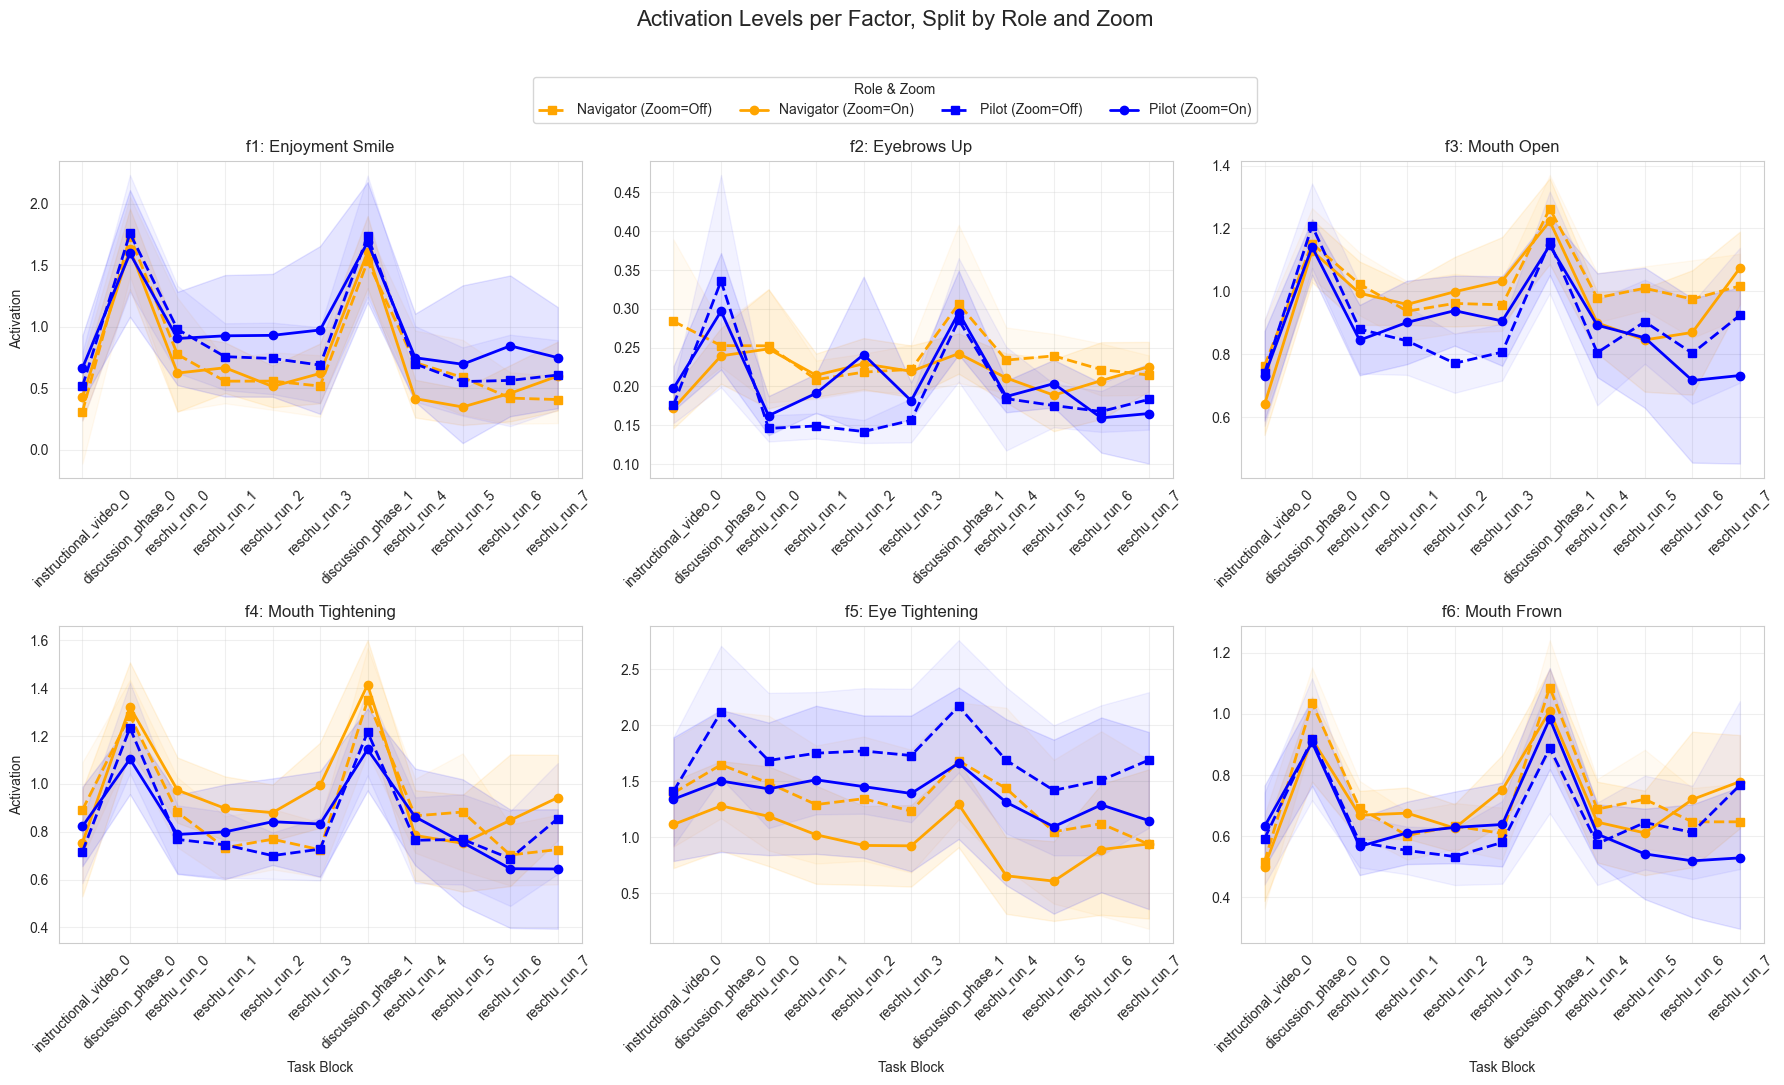

In [5]:
## PLOTTING NAV/PIL ZOOM/NO ZOOM FACTOR ACTIVATION PER PHASE

# 1. Collect all factor data with roles and zoom
all_data = pd.DataFrame(columns=['participant', 'zoom', 'role', 'phase', *FACTORS])

for pair in AVAILABLE_PAIRS:
    p1, p2 = pair.split("_")
    zoom = RESCHU_DATA[pair]['zoom']  # Assuming this returns True/False
    
    for phase in PHASES:
        p1_file = os.path.join(LOCATION, pair, FEATURE_FOLDER, f'pp{p1}_{phase}_factors.csv')
        p2_file = os.path.join(LOCATION, pair, FEATURE_FOLDER, f'pp{p2}_{phase}_factors.csv')
        
        if not os.path.exists(p1_file) and not os.path.exists(p2_file):
            continue
        
        if os.path.exists(p1_file):
            p_df = pd.read_csv(p1_file)
            factors = [np.mean(p_df[f].values) for f in FACTORS]
            all_data.loc[len(all_data)] = [p1, zoom, 'navigator', phase, *factors]
       
        if os.path.exists(p2_file):
            p_df = pd.read_csv(p2_file)
            factors = [np.mean(p_df[f].values) for f in FACTORS]
            all_data.loc[len(all_data)] = [p2, zoom, 'pilot', phase, *factors]

# 2. Melt the dataframe for plotting
plot_df = all_data.melt(id_vars=['participant', 'zoom', 'role', 'phase'], 
                        value_vars=FACTORS,
                        var_name='factor',
                        value_name='activation')

# 3. Calculate statistics including zoom
stats_df = (plot_df.groupby(['zoom', 'role', 'phase', 'factor'])['activation']
            .agg(['mean', 'count', 'std'])
            .reset_index())

stats_df['ci'] = 1.96 * stats_df['std'] / np.sqrt(stats_df['count'])
stats_df['phase'] = pd.Categorical(stats_df['phase'], categories=PHASES, ordered=True)
stats_df = stats_df.sort_values('phase')

# 4. Create plots with zoom split
sns.set_style("whitegrid")
palette = {'pilot': 'blue', 'navigator': 'orange'}
line_styles = {True: '-', False: '--'}  # Solid for zoom=True, dashed for zoom=False
markers = {True: 'o', False: 's'}       # Circle for zoom=True, square for zoom=False

# === Set up grid of subplots ===
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

sns.set_style("whitegrid")
palette = {'pilot': 'blue', 'navigator': 'orange'}
line_styles = {True: '-', False: '--'}  # Solid for zoom=True, dashed for zoom=False
markers = {True: 'o', False: 's'}       # Circle for zoom=True, square for zoom=False

for i, factor in enumerate(FACTORS):
    ax = axes[i]
    
    for (role, zoom), group in stats_df[stats_df['factor'] == factor].groupby(['role', 'zoom']):
        ax.plot(group['phase'], group['mean'], 
                color=palette[role],
                linestyle=line_styles[zoom],
                marker=markers[zoom],
                markersize=6,
                linewidth=2,
                label=f"{role.title()} (Zoom={'On' if zoom else 'Off'})")
        
        ax.fill_between(group['phase'],
                        group['mean'] - group['ci'],
                        group['mean'] + group['ci'],
                        color=palette[role],
                        alpha=0.1 if zoom else 0.05)
    
    ax.set_title(f'{factor}: {FACTOR_LABELS[factor]}', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    if i % 3 == 0:
        ax.set_ylabel("Activation")
    if i >= 3:
        ax.set_xlabel("Task Block")

# Shared legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='Role & Zoom', loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=4)

fig.suptitle("Activation Levels per Factor, Split by Role and Zoom", fontsize=16, y=1.08)
plt.tight_layout()
if SAVE_FIG:
    plt.savefig("activation_factors_by_zoom_and_role.png", dpi=300, bbox_inches='tight')
plt.show()

# cRQA

## Validation 

<bound method NDFrame.head of                pair               phase  method factor  radius  \
0             05_06  discussion_phase_0  factor     f1   0.001   
1             05_06  discussion_phase_0  factor     f1   0.001   
2             05_06  discussion_phase_1  factor     f1   0.001   
3             05_06  discussion_phase_1  factor     f1   0.001   
4             05_06        reschu_run_0  factor     f1   0.001   
...             ...                 ...     ...    ...     ...   
112051  97_98_05_06        reschu_run_1  factor     f6   0.500   
112052  97_98_05_06        reschu_run_2  factor     f6   0.500   
112053  97_98_05_06        reschu_run_2  factor     f6   0.500   
112054  97_98_05_06        reschu_run_3  factor     f6   0.500   
112055  97_98_05_06        reschu_run_3  factor     f6   0.500   

       non_event_matches condition      RR  
0               included      real  0.0002  
1               excluded      real  0.0002  
2               included      real  0.0003

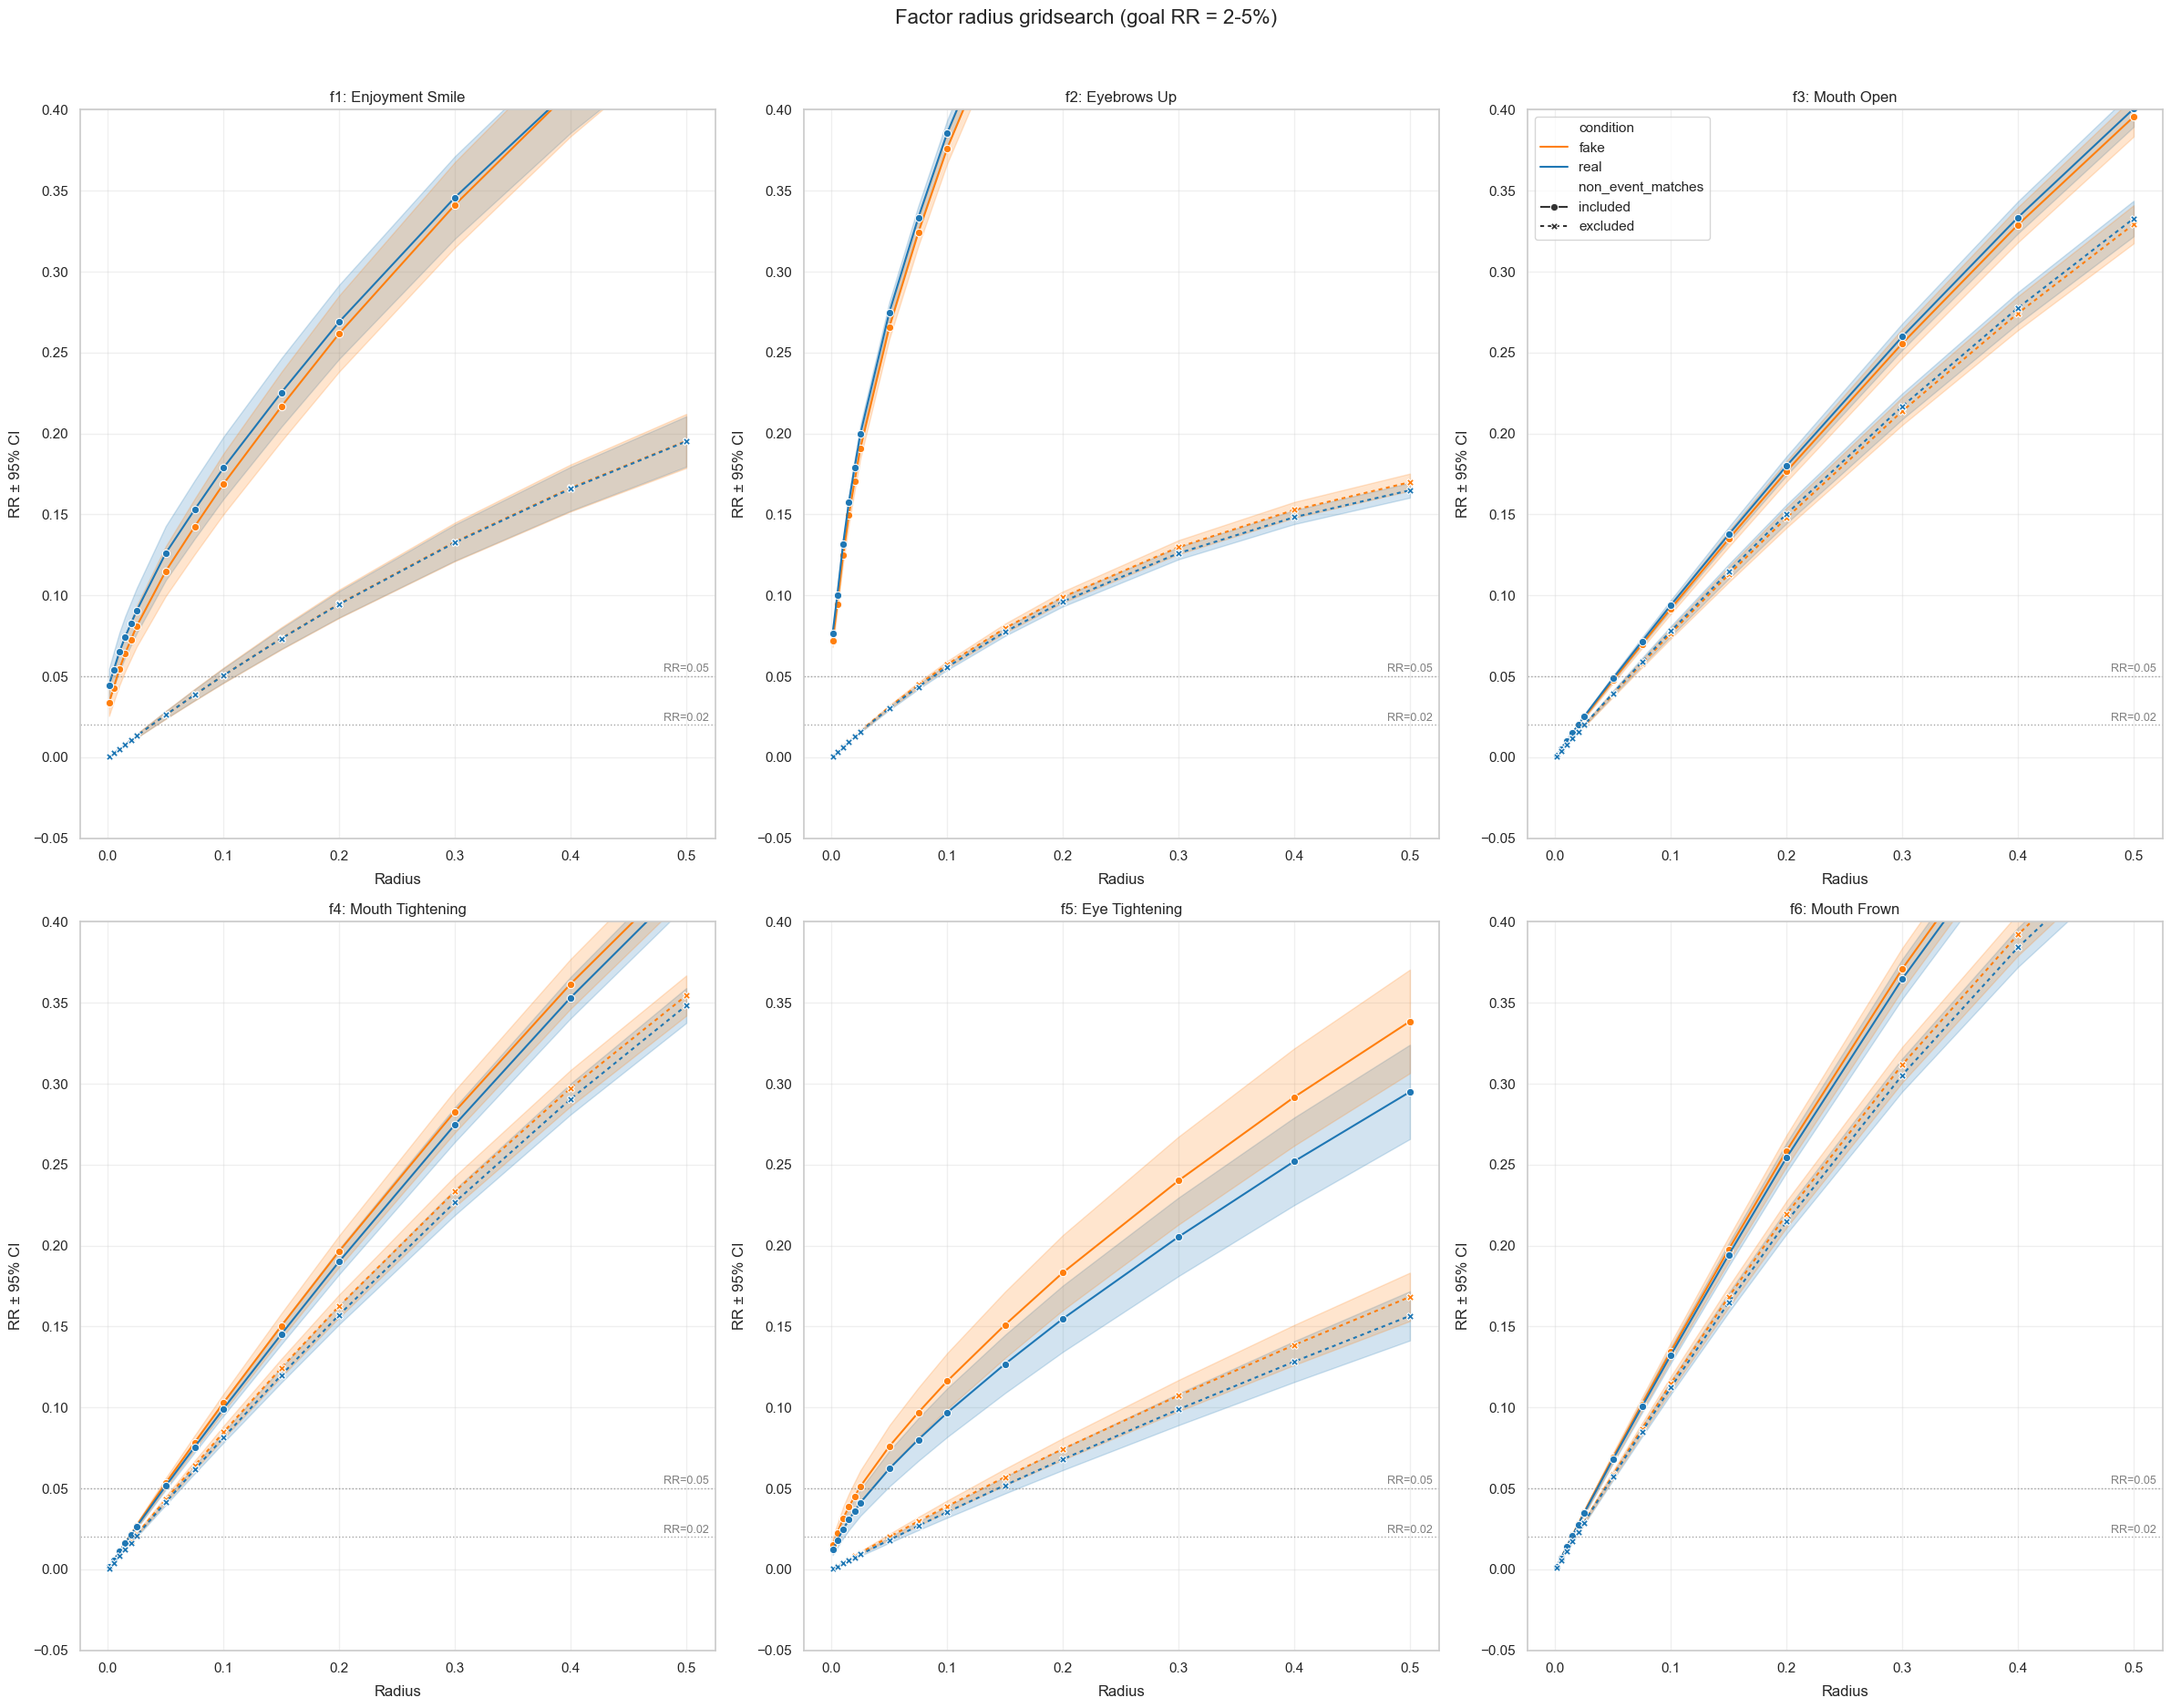

In [6]:
# Perform gridsearch to find out which radius to choose (2-5% RR) - Adjust RADIUS constant in first cell
if True:
    #toolbox.crqa_radius_gridsearch("crqa_gridsearch", radii = [0.001, 0.005, 0.010, 0.015, 0.020, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5], AVAILABLE_PAIRS=AVAILABLE_PAIRS)
    df = pd.read_csv('results/gridsearch.csv')
    print(df.head)
    #df = df[df['non_event_matches'] == NON_EVENT_MATCHES]
    toolbox.plot_crqa_radius_gridsearch(df, "crqa_gridsearch")


In [7]:
# Perform aggregated 
df = pd.read_csv('results/gridsearch.csv')
df = df[df['non_event_matches'] == NON_EVENT_MATCHES]
df = df[df.apply(lambda row: row['radius'] == RADIUS.get(row['factor']), axis=1)] # these are taken from the first import
print(val.process_dataframe(df, "aggregated"))

  factor    comparison  statistic   p_value  n_real  n_fake     p_fdr
0     f1  real_vs_fake      854.0  0.527231      42      41  0.640492
1     f2  real_vs_fake      824.0  0.633660      42      41  0.640492
2     f3  real_vs_fake      880.0  0.433094      42      41  0.640492
3     f4  real_vs_fake      822.0  0.640492      42      41  0.640492
4     f5  real_vs_fake      845.0  0.559730      42      41  0.640492
5     f6  real_vs_fake      853.0  0.530855      42      41  0.640492


Significant comparisons (Mann-Whitney U, FDR-corrected):
  factor    comparison  statistic   p_value  n_real  n_fake     p_fdr
0     f1  real_vs_fake      854.0  0.527231      42      41  0.640492
1     f2  real_vs_fake      824.0  0.633660      42      41  0.640492
2     f3  real_vs_fake      880.0  0.433094      42      41  0.640492
3     f4  real_vs_fake      822.0  0.640492      42      41  0.640492
4     f5  real_vs_fake      845.0  0.559730      42      41  0.640492
5     f6  real_vs_fake      853.0  0.530855      42      41  0.640492
Remaining factors for aggregated: []



C:\Users\Erik\AppData\Local\Temp\ipykernel_4872\4026471064.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=factor_df, x='condition', y='RR', palette='Set2', inner='box', ax=ax)
C:\Users\Erik\AppData\Local\Temp\ipykernel_4872\4026471064.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=factor_df, x='condition', y='RR', palette='Set2', inner='box', ax=ax)
C:\Users\Erik\AppData\Local\Temp\ipykernel_4872\4026471064.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=factor_df, x='condition', y='RR', palette='Set2

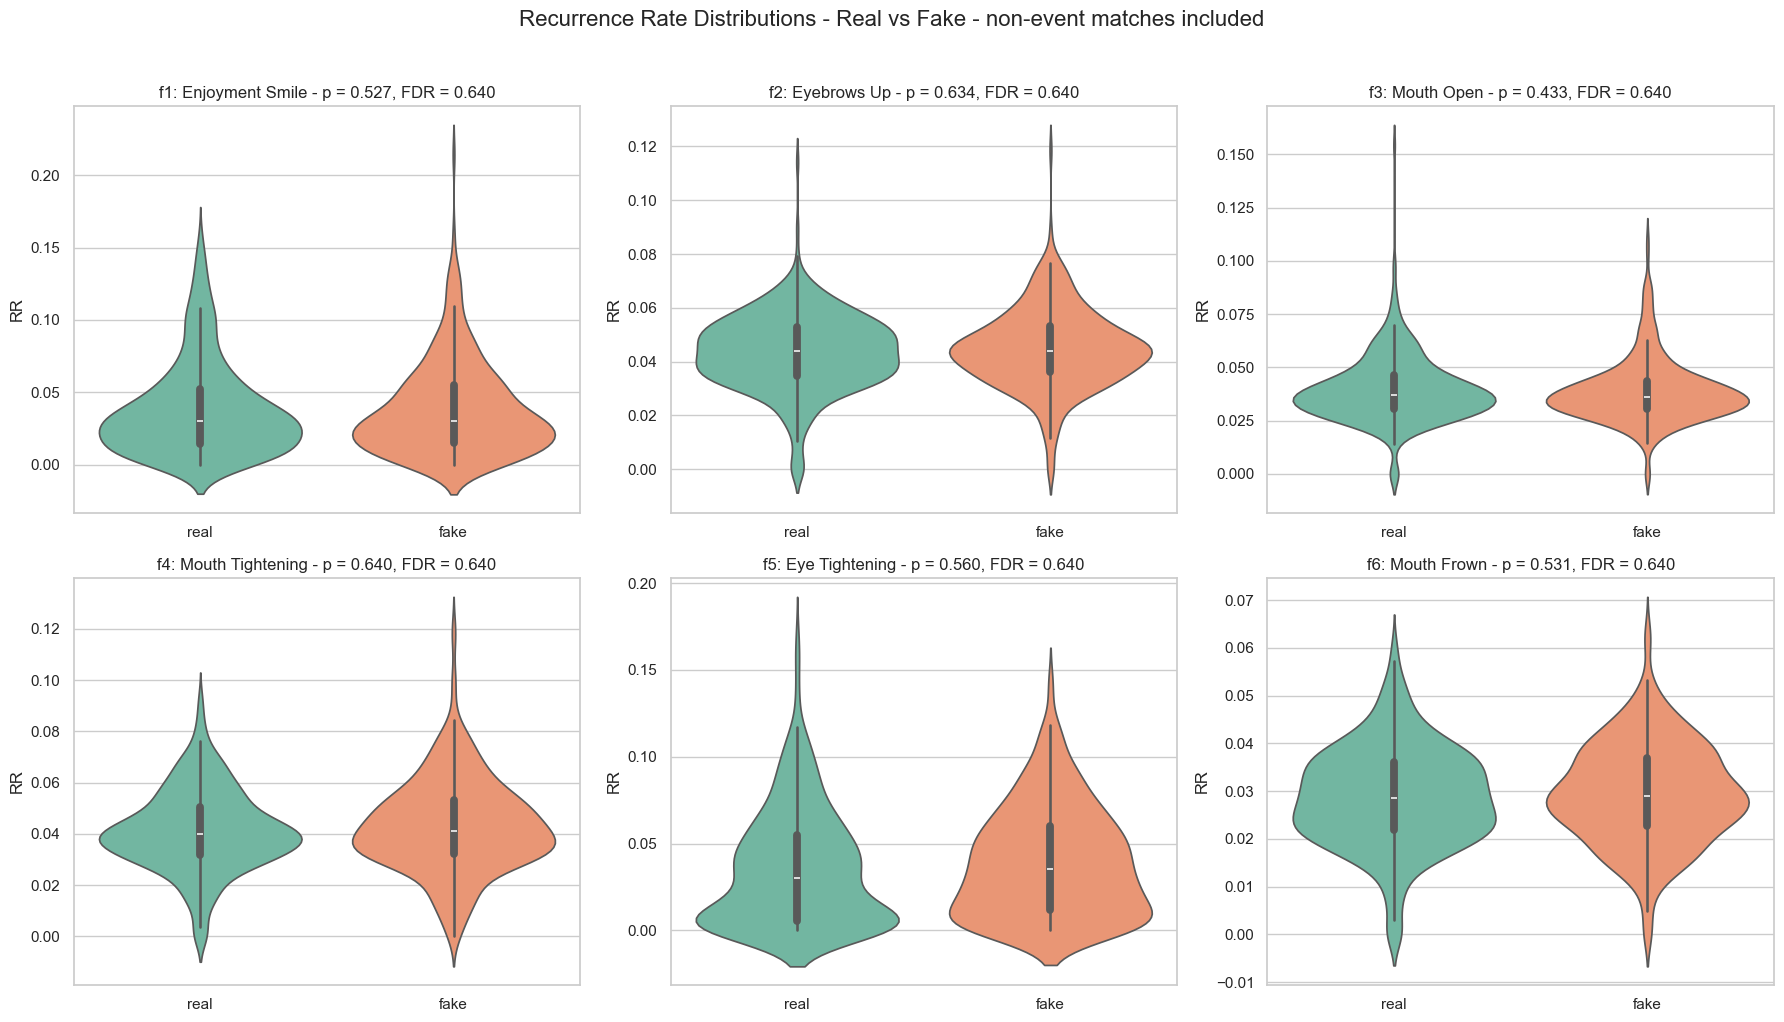

In [8]:

# Load and filter data
df = pd.read_csv('results/gridsearch.csv')
df = df[df['non_event_matches'] == NON_EVENT_MATCHES]
df = df[df.apply(lambda row: row['radius'] == RADIUS.get(row['factor']), axis=1)]
df['condition'] = df['condition'].str.lower()
df = df[df['condition'].isin(['real', 'fake'])]
#df = df[df['phase'].str.contains('reschu_run')]

# Get stats
results_df = val.process_dataframe(df, "aggregated", True)

# Plot setup
sns.set(style='whitegrid')
factors = df['factor'].unique()
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, factor in enumerate(factors):
    ax = axes[i]
    factor_df = df[df['factor'] == factor]

    # Get p-values
    try:
        p = results_df[results_df['factor'] == factor]['p_value'].values[0]
        p_fdr = results_df[results_df['factor'] == factor]['p_fdr'].values[0]
        title = f'{factor}: {FACTOR_LABELS[factor]} - p = {p:.3f}, FDR = {p_fdr:.3f}'
    except IndexError:
        title = f'{factor}: {FACTOR_LABELS[factor]} - p = n/a'

    # Plot
    sns.violinplot(data=factor_df, x='condition', y='RR', palette='Set2', inner='box', ax=ax)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('RR')

# Remove unused subplot if <6 factors
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Recurrence Rate Distributions - Real vs Fake - non-event matches included", fontsize=16, y=1.02)
plt.tight_layout()
if SAVE_FIG: fig.savefig("rr_distributions_real_vs_fake.png", dpi=300, bbox_inches='tight')
plt.show()


In [9]:
if False:
    df = pd.read_csv('results/cRQA_gridsearch_RR.csv')
    toolbox.plot_crqa_radius_gridsearch(df, "cRQA_gridsearch_RR")


c:\Users\Erik\Documents\facial-expression-synchrony\util\visualisation.py:123: SyntaxWarning: invalid escape sequence '\d'
  reschu_df['run_number'] = reschu_df['phase'].str.extract('(\d+)').astype(int)


f1 2832726 8868686
f2 4922508 8868686
f3 1020395 8868686
f4 1054718 8868686
f5 1795883 8868686
f6 1127348 8868686


c:\Users\Erik\Documents\facial-expression-synchrony\util\visualisation.py:345: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=ratio_df, x='factor', y='percentage', ci=None)


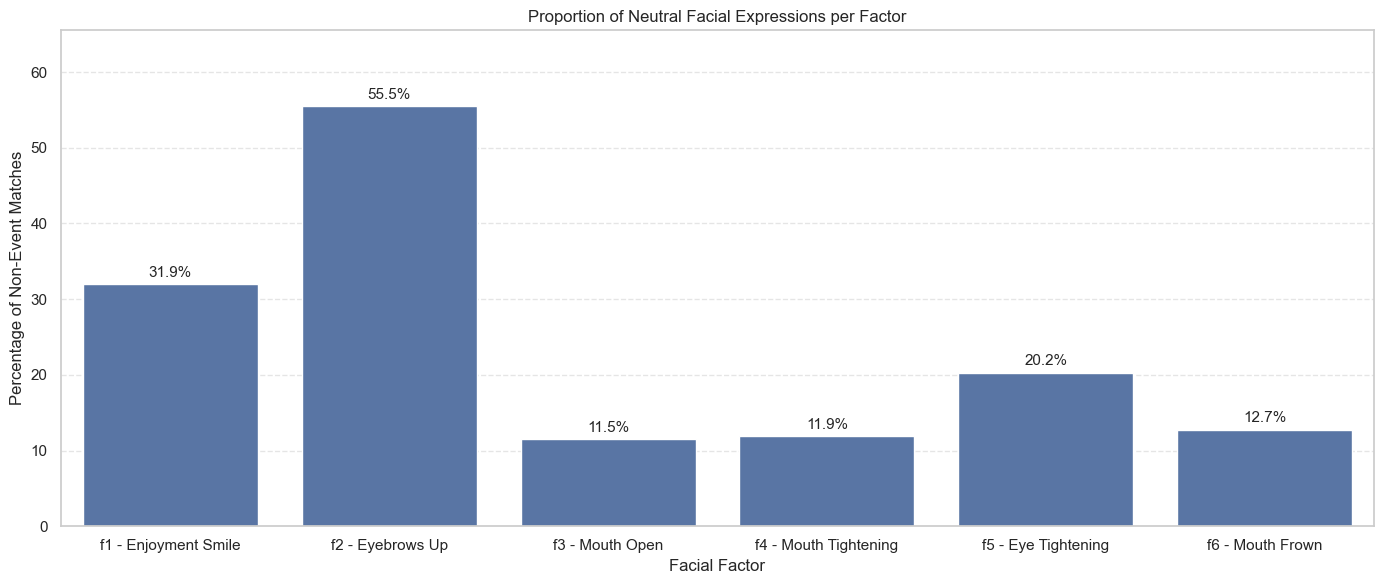

In [10]:
import util.visualisation as vis
ratios = vis.calculate_non_event_match_ratio(
    location=LOCATION,
    feature_folder=FEATURE_FOLDER,
    pairs=AVAILABLE_PAIRS,
    phases=PHASES,
    factors=FACTORS,
    threshold=0.08,
    debug=True
)


# cRQA run

In [11]:
full_run = False


# intitialize global dataframes for further analysis 
joined_RR_overall = pd.DataFrame(columns=['pair', 'zoom', 'phase', 'beeps', 'score',*FACTORS])
joined_RR_profile = pd.DataFrame(columns=['pair', 'zoom', 'phase', 'beeps', 'score', 'factor', *np.arange(-60,61)])

for pair in AVAILABLE_PAIRS:
    # skip if its already made, IF we do not plan to use global dataframes
    if not full_run and os.path.exists(os.path.join(LOCATION, pair, CORRELATION_FOLDER, f'{pair}_rr_overall.csv')) and os.path.exists(os.path.join(LOCATION, pair, CORRELATION_FOLDER, f'{pair}_rr_profile.csv')) :
            print(f"{pair} is skipped because we already computed the recurrence rates... ")
            continue
    
    print(f'{pair} is being processed')

    p1, p2 = pair.split("_")
    # local (pair) dataframes
    RR_overall = pd.DataFrame(columns=['zoom', 'phase', 'beeps', 'score', *FACTORS])
    RR_profile = pd.DataFrame(columns=['zoom', 'phase', 'beeps', 'score', 'factor', *np.arange(-60,61)])

    pair_data = RESCHU_DATA[pair]
    zoom = pair_data['zoom']
    files = os.path.join(LOCATION, pair, FEATURE_FOLDER)
    for phase in PHASES:
        if 'reschu' in phase:
            if len(pair_data['score']) > int(phase[-1]):
                beeps = pair_data['beeps'][int(phase[-1])]
                score = pair_data['score'][int(phase[-1])][1]
            else:
                beeps = None
                score = None
        else: 
            beeps = None
            score = None

        components = []
        nav_file = os.path.join(files,f'pp{p1}_{phase}_factors.csv')
        pil_file = os.path.join(files,f'pp{p2}_{phase}_factors.csv')

        # check whether we are able to process
        if not (os.path.exists(nav_file) and os.path.exists(pil_file)):
            print(f'{pair}-{phase} does not have both factor files')
            continue
        
        for f in FACTORS:
            nav = pd.read_csv(nav_file)
            pil = pd.read_csv(pil_file)

            # perform crqa
            fac = cm.crqa_lag_analysis(nav[f].values, pil[f].values, radius=RADIUS[f], remove_non_event_matches=REMOVE_NEM[f])
            components.append(fac['RR'])

            # add RR_profile for each factor separately
            RR_profile.loc[len(RR_profile)] = [zoom, phase, beeps, score, f, *fac['rr_profile']]
            joined_RR_profile.loc[len(joined_RR_profile)] = [pair, zoom, phase, beeps, score, f, *fac['rr_profile']]
        
        # add RR_overall for all factors at once
        RR_overall.loc[len(RR_overall)] = [zoom, phase, beeps, score, *components]
        joined_RR_overall.loc[len(joined_RR_overall)] = [pair, zoom, phase, beeps, score, *components]
        
    # save local dataframes in correct folder
    RR_overall.to_csv(os.path.join(LOCATION, pair, CORRELATION_FOLDER, f'{pair}_rr_overall.csv'), index=False)
    RR_profile.to_csv(os.path.join(LOCATION, pair, CORRELATION_FOLDER, f'{pair}_rr_profile.csv'), index=False)

# do not change it not needed
if full_run:
    joined_RR_overall.to_csv(f"{ANALYSIS_FILENAME}_overall.csv", index=False) 
    joined_RR_profile.to_csv(f"{ANALYSIS_FILENAME}_profile.csv", index=False)


05_06 is skipped because we already computed the recurrence rates... 
07_08 is skipped because we already computed the recurrence rates... 
09_10 is skipped because we already computed the recurrence rates... 
99_100 is skipped because we already computed the recurrence rates... 
101_102 is skipped because we already computed the recurrence rates... 
103_104 is skipped because we already computed the recurrence rates... 
13_14 is skipped because we already computed the recurrence rates... 
17_18 is skipped because we already computed the recurrence rates... 
19_20 is skipped because we already computed the recurrence rates... 
21_22 is skipped because we already computed the recurrence rates... 
25_26 is skipped because we already computed the recurrence rates... 
27_28 is skipped because we already computed the recurrence rates... 
29_30 is skipped because we already computed the recurrence rates... 
31_32 is skipped because we already computed the recurrence rates... 
33_34 is skippe

# Analysis

In [12]:
# SCORES OUT OF ENQUETE
## POST TRIAL TEAMWORK ASSESSMENT (per reschu_run)
post_trial = pd.read_csv('RESCHU-data/post_trial_enquete.csv')
post_trial = post_trial[['ParticipantID', 'Trial', 'Teamwork_1']] # TODO: extend if needed to fit more


## POST STUDY COHESION COOPERATION AN DEMPATHY ASSESSMENT
post_study = pd.read_csv('RESCHU-data/post_study_enquete.csv')
post_study['Cohe'] = (post_study['Cohesion_1'] + post_study['Cohesion_2'] + post_study['Cohesion_3'] + post_study['Cohesion_4'] + post_study['Cohesion_5'])/5
post_study['Coop'] = (post_study['Cooperation_1'] + post_study['Cooperation_2'] + post_study['Cooperation_3'] + post_study['Cooperation_4'] + post_study['Cooperation_5'] + post_study['Cooperation_6'] + post_study['Cooperation_7'] + post_study['Cooperation_8'] + post_study['Cooperation_9'])/9
for i in range(2,6):
    post_study['Cohesion_1'] = post_study['Cohesion_1'] + post_study[f'Cohesion_{i}']
post_study['Cohesion_1'] = post_study['Cohesion_1']/5
for i in range(2,10):
    post_study['Cooperation_1'] = post_study['Cooperation_1'] + post_study[f'Cooperation_{i}']
post_study['Cooperation_1'] = post_study['Cooperation_1']/9
for i in range(2,24):
    post_study['Empathy_1'] = post_study['Empathy_1'] + post_study[f'Empathy_{i}']
post_study['Empathy_1'] = post_study['Empathy_1']/23
post_study = post_study[['ParticipantID', 'Cohesion_1', 'Cooperation_1', 'Empathy_1']]



STUDY_ENQUETE = {}
TRIAL_ENQUETE = {}
for pair in AVAILABLE_PAIRS:
    p1, p2 = pair.split("_")
    p1_study = post_study[post_study['ParticipantID']== int(p1)]
    p2_study = post_study[post_study['ParticipantID']== int(p2)]

    p1_trial = post_trial[post_trial['ParticipantID'] == int(p1)]
    p2_trial = post_trial[post_trial['ParticipantID'] == int(p2)]

    trial = {}
    for i in range(1,9):
        p1_t = p1_trial[p1_trial['Trial'] == i]
        p2_t = p2_trial[p2_trial['Trial'] == i]
        if len(p1_t) > 0 and len(p2_t) > 0:
            trial[i] = p1_t['Teamwork_1'].values[0] + p2_t['Teamwork_1'].values[0]
    
    TRIAL_ENQUETE[pair] = trial

    if len(p1_study) > 0 and len(p2_study) > 0:
        STUDY_ENQUETE[pair] = {
            'Cohesion' : p1_study['Cohesion_1'].values[0] + p2_study['Cohesion_1'].values[0],
            'Cooperation' : p1_study['Cooperation_1'].values[0] + p2_study['Cooperation_1'].values[0],
            'Empathy': p1_study['Empathy_1'].values[0] + p2_study['Empathy_1'].values[0]
        }


print(TRIAL_ENQUETE['51_52'])
print(STUDY_ENQUETE['51_52'])

df = pd.read_csv(f'{ANALYSIS_FILENAME}_overall.csv')

cohesion = []
cooperation = []
empathy = []
teamwork = []
for _, row in df.iterrows():
    if 'reschu' not in row['phase']: 
        teamwork.append(None)
    else:
        phase = int(row['phase'][-1]) + 1
        if phase in TRIAL_ENQUETE[row['pair']]:
            teamwork.append(TRIAL_ENQUETE[row['pair']][phase])
        else:
            teamwork.append(None)

    if row['pair'] in STUDY_ENQUETE:
        dic = STUDY_ENQUETE[row['pair']]
        cohesion.append(dic['Cohesion'])
        cooperation.append(dic['Cooperation'])
        empathy.append(dic['Empathy'])
    else:
        cohesion.append(None)
        cooperation.append(None)
        empathy.append(None)

df['Teamwork'] = teamwork
df['Cohesion'] = cohesion
df['Cooperation'] = cooperation
df['Empathy'] = empathy
df.head()

df.to_csv(f'{ANALYSIS_FILENAME}_overall_questionnaire.csv')


{2: 140.0, 3: 179.0, 4: 133.0, 5: 55.0, 6: 174.0, 7: 98.0, 8: 178.0}
{'Cohesion': 11.4, 'Cooperation': 8.666666666666666, 'Empathy': 8.695652173913043}


processing is done. you now have everything you need. The rest of the analysis is in analysis.ipynb. 



thank you for using my code x Erik

In [19]:
df = pd.read_csv('results/NEM excl/crqa_NEM-_overall.csv')
df['RR'] = df['f1'] + df['f2'] + df['f3'] + df['f4'] + df['f5'] + df['f6']
df = df.sort_values('RR', ascending=False)
df.head()

,pair,zoom,phase,beeps,score,f1,f2,f3,f4,f5,f6,RR
171,39_40,False,reschu_run_4,False,21.0,0.1214,0.0641,0.0311,0.0565,0.1577,0.0287,0.4595
73,19_20,False,instructional_video_0,NaN,NaN,0.1373,0.0639,0.0643,0.0822,0.0540,0.0403,0.4420
324,87_88,False,reschu_run_2,False,27.0,0.0945,0.0702,0.0600,0.0599,0.0809,0.0428,0.4083
174,39_40,False,reschu_run_7,True,14.0,0.0982,0.0583,0.0324,0.0524,0.1334,0.0304,0.4051
148,35_36,False,instructional_video_0,NaN,NaN,0.0286,0.0441,0.0534,0.0630,0.1714,0.0377,0.3982
